In [1]:
import gc
import json
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from chinese_calendar import is_holiday
from tqdm import tqdm_notebook
from utils import FlattenDataSimple, loadJSON, loadpkl

%matplotlib inline

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [12]:
# load csv
profiles = pd.read_csv('../input/data_set_phase2/profiles.csv')
test_plans = pd.read_csv('../input/data_set_phase2/test_plans.csv')
test_queries = pd.read_csv('../input/data_set_phase2/test_queries.csv')
train_clicks = pd.read_csv('../input/data_set_phase2/train_clicks_phase2.csv')
train_plans1 = pd.read_csv('../input/data_set_phase1/train_plans.csv')
train_plans = pd.read_csv('../input/data_set_phase2/train_plans_phase2.csv')
train_queries = pd.read_csv('../input/data_set_phase2/train_queries_phase2.csv')
train_queries1 = pd.read_csv('../input/data_set_phase2/train_queries_phase1.csv')

In [3]:
profiles1 = pd.read_csv('../input/data_set_phase1/profiles.csv')

In [3]:
# merge click
train_plans = pd.merge(train_plans, train_clicks[['sid','click_mode']], on='sid', how='left')

# fill na (no click)
train_plans['click_mode'].fillna(0, inplace=True)

# set test target as nan
test_plans['click_mode'] = np.nan

# merge train & test
plans = train_plans.append(test_plans)

del train_plans, test_plans
gc.collect()

# reset index
plans.reset_index(inplace=True,drop=True)

# convert json
for key in tqdm_notebook(['distance', 'price', 'eta', 'transport_mode']):
    plans[key] = plans.plans.apply(lambda x: loadJSON(x,key))

# flatten
plans_df = [FlattenDataSimple(plans, key) for key in tqdm_notebook(['distance', 'price', 'eta', 'transport_mode'])]
plans_df = pd.concat(plans_df,axis=1)

# merge plan_time & click_mode
plans_df = pd.merge(plans_df.reset_index(), plans[['sid','plan_time', 'click_mode']], on='sid',how='outer')

# cleaning
for c in plans_df.columns.to_list():
    if 'price' in c:
        plans_df[c] = plans_df[c].replace('',0)

plans_df['plan_time'] = pd.to_datetime(plans_df['plan_time'])

In [13]:
train_queries = train_queries1.append(train_queries)

train_queries['is_test']=False
test_queries['is_test']=True

queries = train_queries.append(test_queries)

del train_queries, test_queries
gc.collect()

94

In [17]:
# to datetime
queries['req_time'] = pd.to_datetime(queries['req_time'])

# distance features
queries['x_o']=queries['o'].apply(lambda x: x.split(',')[0]).astype(float)
queries['y_o']=queries['o'].apply(lambda x: x.split(',')[1]).astype(float)
queries['x_d']=queries['d'].apply(lambda x: x.split(',')[0]).astype(float)
queries['y_d']=queries['d'].apply(lambda x: x.split(',')[1]).astype(float)

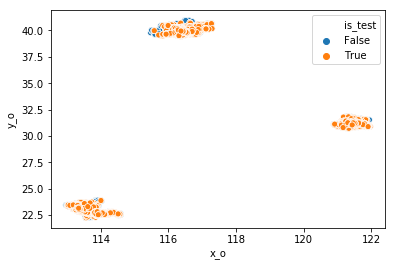

In [18]:
sns.scatterplot(x='x_o',y='y_o',data=queries,hue='is_test')

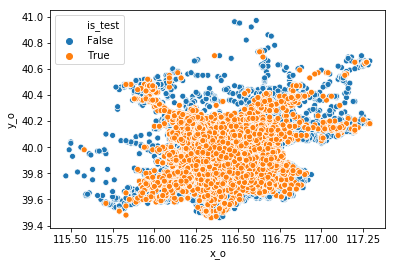

In [19]:
sns.scatterplot(x='x_o',y='y_o',data=queries[queries.y_o>37.5],hue='is_test')

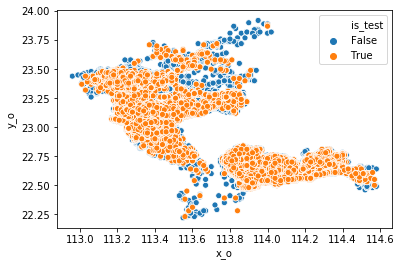

In [20]:
sns.scatterplot(x='x_o',y='y_o',data=queries[queries.y_o<27.5],hue='is_test')

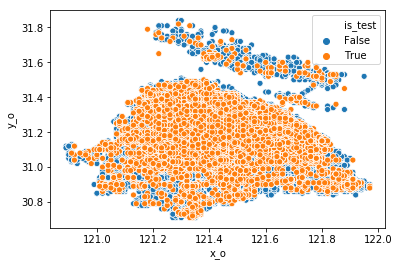

In [21]:
sns.scatterplot(x='x_o',y='y_o',data=queries[queries.x_o>120],hue='is_test')

In [22]:
plans_df.sid.value_counts()

NameError: name 'plans_df' is not defined

In [23]:
queries.sid.value_counts()

2047       1
2209436    1
2115234    1
2121377    1
2119328    1
2207391    1
2205342    1
2211485    1
2199195    1
2127524    1
2197146    1
2203289    1
2201240    1
2223767    1
2221718    1
2227861    1
2117283    1
2129573    1
709616     1
2107054    1
2160308    1
2150067    1
2148018    1
2154161    1
2152112    1
2109103    1
2113197    1
2123430    1
2111148    1
2100907    1
          ..
1707540    1
1717779    1
1719826    1
1713681    1
1758735    1
1830440    1
1760782    1
1754637    1
1756684    1
1766923    1
1768970    1
1762825    1
1709591    1
1732120    1
1730073    1
1736218    1
1734171    1
1723932    1
1721885    1
1728030    1
1725983    1
1814048    1
1812001    1
1818146    1
1816099    1
1805860    1
1803813    1
1809958    1
1807911    1
0          1
Name: sid, Length: 2304916, dtype: int64

In [24]:
queries[queries.sid==853273]

,sid,pid,req_time,o,d,is_test,x_o,y_o,x_d,y_d
143742,853273,2570.0,2018-10-21 08:26:40,"121.53,31.19","121.32,31.20",False,121.53,31.19,121.32,31.2
